In [1]:
import discretisedfield as df
import micromagneticmodel as mm
import oommfc as oc
import numpy as np

mesh = df.Mesh(p1=(0, 0, 0), p2=(5e-9, 1e-9, 1e-9), n=(5, 1, 1)) 

In [2]:
H = (1, 0, 0)
H_field = df.Field(mesh, dim=3, value=H)

In [3]:
Ms = 1
A = 1
D = 1
mu0 = 4 * np.pi * 1e-7

In [4]:
def m_value(point):
    x, y, z = point
    c = 1e9
    return (c*x, c*x+10, c*x+20)

array([[[[0.88983372]]],


       [[[0.88012072]]],


       [[[0.87006284]]],


       [[[0.85996395]]],


       [[[0.85002345]]]])

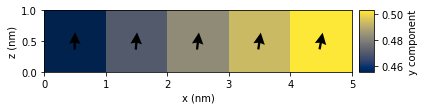

In [5]:
m = df.Field(mesh, dim=3, value=m_value, norm=Ms, bc='neumann')
m.plane('y').mpl()

m.z.array

In [6]:
system = mm.System(name='mysystem')

system.energy = mm.Zeeman(H=H) + mm.Exchange(A=A) + mm.DMI(D=D, crystalclass='T')
system.m = m

## Zeeman

In [7]:
wdf = -mu0 * Ms * m @ H_field
wdf.array

array([[[[-2.72731227e-08]]],


       [[[-7.71622547e-08]]],


       [[[-1.21483690e-07]]],


       [[[-1.60949745e-07]]],


       [[[-1.96194669e-07]]]])

In [8]:
woc = oc.compute(system.energy.zeeman.density, system)
woc.array

Running OOMMF (ExeOOMMFRunner) [2020/06/04 12:08]... (1.7 s)


array([[[[-2.72731227e-08]]],


       [[[-7.71622547e-08]]],


       [[[-1.21483690e-07]]],


       [[[-1.60949745e-07]]],


       [[[-1.96194669e-07]]]])

In [9]:
np.allclose(wdf.array, woc.array)

True

# Exchange

In [10]:
m.bc

'neumann'

In [11]:
#wdf = A * (m.x.grad.norm**2 + m.y.grad.norm**2 + m.z.grad.norm**2)
#wdf = -A * m @ df.stack([m.x.grad.div, m.y.grad.div, m.z.grad.div])
wdf = -A * m @ m.laplacian
wdf.array

neumann
edge
neumann
edge
neumann
edge


array([[[[ 9.47642764e+14]]],


       [[[-1.14326731e+15]]],


       [[[-9.03121864e+14]]],


       [[[-7.18123981e+14]]],


       [[[-9.67410322e+14]]]])

In [12]:
woc = oc.compute(system.energy.exchange.density, system)
woc.array

Running OOMMF (ExeOOMMFRunner) [2020/06/04 12:08]... (1.9 s)


array([[[[9.47642764e+14]]],


       [[[1.69966098e+15]]],


       [[[1.35293279e+15]]],


       [[[1.08461973e+15]]],


       [[[4.83705161e+14]]]])

In [13]:
np.allclose(wdf.array, woc.array)

False

## DMI

In [14]:
m.bc is None

False

In [15]:
wdf = D * m @ m.curl
wdf.array

neumann
edge
neumann
edge


array([[[[ 8884414.02610536]]],


       [[[16799249.52537297]]],


       [[[14990227.25451686]]],


       [[[13423542.24644487]]],


       [[[ 6348150.49119563]]]])

In [16]:
woc = oc.compute(system.energy.dmi.density, system)
woc.array

Running OOMMF (ExeOOMMFRunner) [2020/06/04 12:08]... (1.8 s)


array([[[[ 8884414.02610537]]],


       [[[16799249.525373  ]]],


       [[[14990227.2545168 ]]],


       [[[13423542.2464449 ]]],


       [[[ 6348150.49119562]]]])

In [17]:
np.allclose(wdf.array, woc.array)

True

## Anisotropy

In [18]:
m.array

array([[[[0.02170326, 0.45576849, 0.88983372]]],


       [[[0.06140377, 0.47076225, 0.88012072]]],


       [[[0.09667365, 0.48336824, 0.87006284]]],


       [[[0.12807974, 0.49402184, 0.85996395]]],


       [[[0.15612676, 0.50307511, 0.85002345]]]])

In [19]:
m0 = np.squeeze(m.array[0, ...])
m1 = np.squeeze(m.array[1, ...])
m2 = np.squeeze(m.array[2, ...])
m3 = np.squeeze(m.array[3, ...])
m4 = np.squeeze(m.array[4, ...])

In [20]:
((1 - np.dot(m2, m1)) + (1 - np.dot(m3, m2))) / (1e-9**2) /1e15

1.352932788508898

In [21]:
(1 - np.dot(m3, m4)) / (1e-9**2) /1e15

0.4837051612478493

Second order exchange expression

In [22]:
def deriv2(i):
    return (m4[i] - 2*m4[i] + m3[i])/(1e-9**2)

def deriv2(i):
    return (m4[i] - 2*m4[i] + m3[i])/(1e-9**2)

np.dot(m4, np.array([deriv2(0), deriv2(1), deriv2(2)]))/1e15

-0.483705161247863

In [23]:
d2mx = m.x.derivative('x').derivative('x')
d2my = m.y.derivative('x').derivative('x')
d2mz = m.z.derivative('x').derivative('x')

neumann
edge
neumann
edge
neumann
edge
neumann
edge
neumann
edge
neumann
edge


In [24]:
d2mx.array

array([[[[ 8.81746941e+15]]],


       [[[ 6.74386411e+15]]],


       [[[-3.87931983e+15]]],


       [[[-9.65723667e+15]]],


       [[[-7.85152214e+15]]]])

In [25]:
def deriv2(i):
    return (m4[i] - 2*m3[i] + m2[i])/(1e-9**2)

deriv2(0)

-3359069036622225.0

In [26]:
(m @ df.stack([d2mx, d2my, d2mz])).array

array([[[[-6.09738446e+14]]],


       [[[-9.11034285e+14]]],


       [[[-1.38722531e+15]]],


       [[[-7.95049884e+14]]],


       [[[-4.19649886e+14]]]])